# Reading SEG-Y files

In [21]:
#!mkdir -p datasets
#!wget -P datasets https://s3.amazonaws.com/open.source.geoscience/open_data/usgs/2Dseismic/ConocoPhillips/Fishbone_395_PR.sgy
#!ls -lh datasets/

In [22]:
import segyio
import matplotlib.pyplot as plt
import numpy as np


# Create realistic synthetic seismic data

In [23]:
spec = segyio.spec()
filename = 'datasets/synthetic.sgy'


spec.sorting = 2
spec.format = 1
spec.samples = np.arange(250)  # Array of sample indices
spec.ilines = np.arange(1, 2)    # Just 1 inline (2D line)
spec.xlines = np.arange(1, 101)  # 100 traces

with segyio.create(filename, spec) as f:
    for j, xline in enumerate(spec.xlines):
        # Create seismic-like trace with multiple reflectors
        t = np.linspace(0, 2, len(spec.samples))
        
        # Add several reflectors at different depths
        trace = np.zeros(len(spec.samples), dtype=np.float32)
        trace += 2.0 * np.exp(-((t - 0.3)**2) / 0.01) * np.sin(2*np.pi*30*t)  # Strong reflector
        trace += 1.5 * np.exp(-((t - 0.7)**2) / 0.015) * np.sin(2*np.pi*25*t) # Medium reflector
        trace += 1.0 * np.exp(-((t - 1.2)**2) / 0.02) * np.sin(2*np.pi*20*t)  # Weaker reflector
        trace += 0.8 * np.exp(-((t - 1.6)**2) / 0.025) * np.sin(2*np.pi*15*t) # Deep reflector
        
        # Add lateral variation (dipping event)
        trace += 1.2 * np.exp(-((t - 0.5 - j*0.003)**2) / 0.02) * np.sin(2*np.pi*22*t)
        
        # Add noise
        trace += np.random.randn(len(spec.samples)) * 0.15
        
        f.trace[j] = trace
        f.header[j] = {
            segyio.TraceField.INLINE_3D: 1,
            segyio.TraceField.CROSSLINE_3D: int(xline),
        }

print("Created ", filename)

Created  datasets/synthetic.sgy


In [24]:

with segyio.open(filename, 'r') as f:
    print(f"Data shape: {f.trace.raw[:].shape}")
    print(f"First trace values (first 10 samples):")
    print(f.trace[0][:10])
    print(f"\nSecond trace values (first 10 samples):")
    print(f.trace[1][:10])


Data shape: (100, 250)
First trace values (first 10 samples):
[-0.10590041 -0.11675775 -0.06141996 -0.2829929  -0.00784617  0.02156606
 -0.11944938 -0.19530559  0.03770952  0.1925906 ]

Second trace values (first 10 samples):
[-0.00166738  0.13112688  0.09022427  0.11806512  0.2667681   0.2102629
  0.11546761  0.19730651 -0.14725775 -0.17749041]


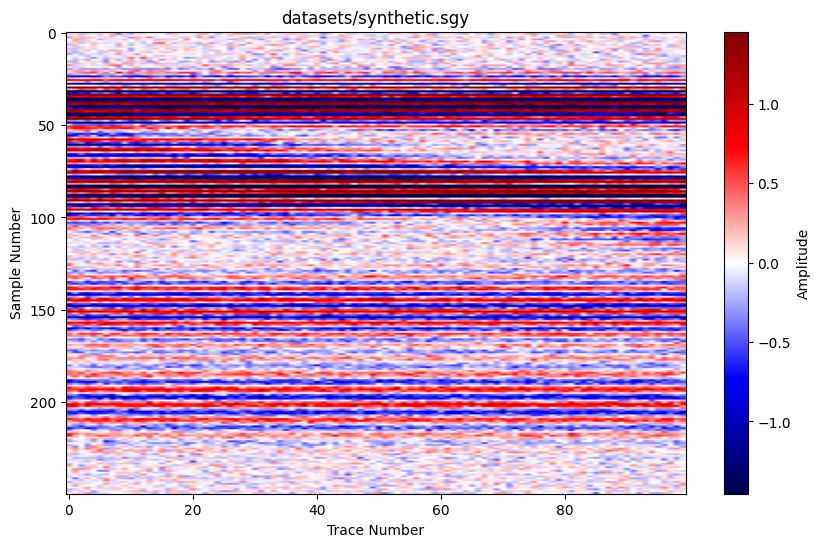

In [25]:

# Open and read the SEG-Y file
with segyio.open(filename, 'r') as f:
    # Read all traces
    data = f.trace.raw[:].T  # Transpose: time on vertical axis
    
    # Display
    plt.figure(figsize=(10, 6))
    plt.imshow(data, aspect='auto', cmap='seismic', 
               vmin=-np.percentile(np.abs(data), 95),
               vmax=np.percentile(np.abs(data), 95))
    plt.colorbar(label='Amplitude')
    plt.xlabel('Trace Number')
    plt.ylabel('Sample Number')
    plt.title(filename)
    plt.show()